In [1]:
# Common import

import os


import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import vgg16
from keras import backend as K

from functools import reduce # for union of more than 2 arrays
BatchNormalization
from helper_functions import *

# This is simply an alias for convenience
layers = tf.keras.layers

#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# The function load_fata (helper_functions.py) performes the operation mentioned above.
DataList, Labels = load_data(hf)
hf.close() # closing file

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



In [3]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


In [4]:
# Computing Features through the function calc_features (helper_functions.py)
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)

In [5]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

Scatter Plots: X, Y, Z


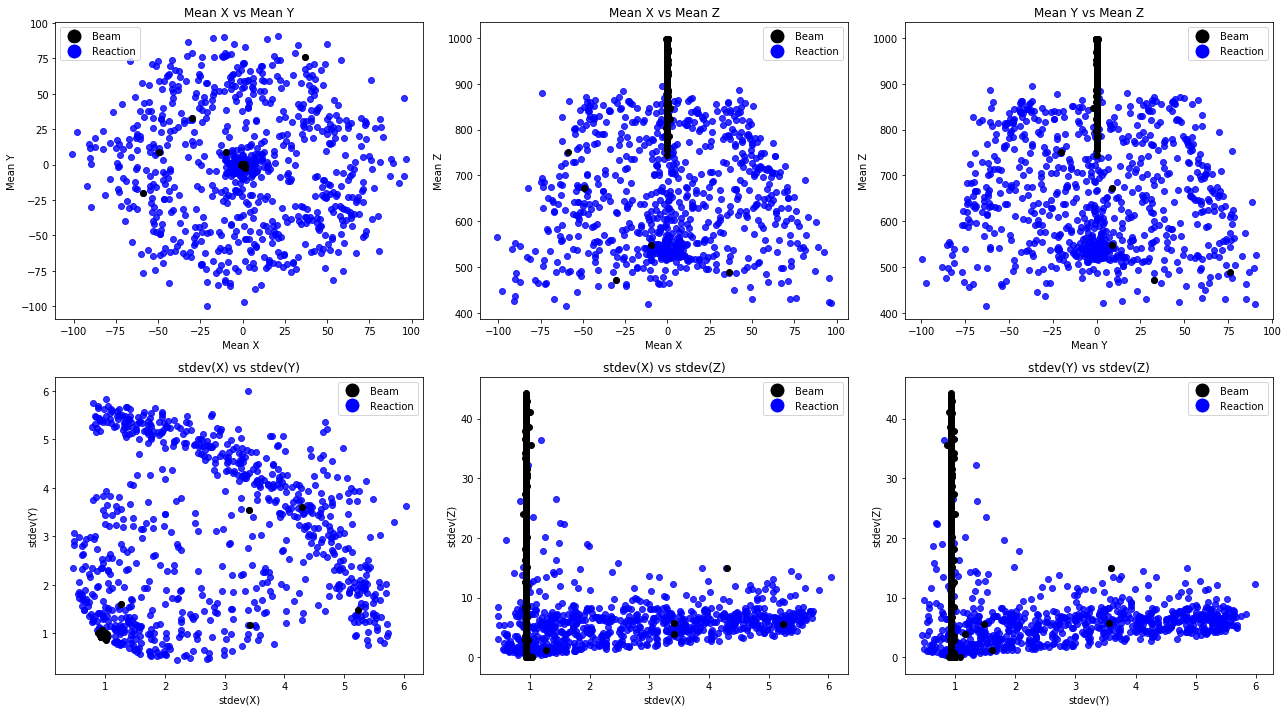

In [6]:
print("Scatter Plots: X, Y, Z")
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Mean values
ax[0][0].scatter(MeanXPerEvent[train_r_idx],MeanYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][0].scatter(MeanXPerEvent[train_b_idx],MeanYPerEvent[train_b_idx], c = b_color)
ax[0][0].set_title("Mean X vs Mean Y")
ax[0][0].set_xlabel(" Mean X")
ax[0][0].set_ylabel("Mean Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color,  alpha=0.8)
ax[0][1].scatter(MeanXPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][1].set_title("Mean X vs Mean Z")
ax[0][1].set_xlabel("Mean X")
ax[0][1].set_ylabel("Mean Z")
ax[0][1].legend(handles=legend_elements)

ax[0][2].scatter(MeanYPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][2].scatter(MeanYPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][2].set_title("Mean Y vs Mean Z")
ax[0][2].set_xlabel("Mean Y")
ax[0][2].set_ylabel("Mean Z")
ax[0][2].legend(handles=legend_elements)

# Standard Deviations
ax[1][0].scatter(StDevXPerEvent[train_r_idx],StDevYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][0].scatter(StDevXPerEvent[train_b_idx],StDevYPerEvent[train_b_idx], c = b_color)
ax[1][0].set_title("stdev(X) vs stdev(Y)")
ax[1][0].set_xlabel("stdev(X)")
ax[1][0].set_ylabel("stdev(Y)")
ax[1][0].legend(handles=legend_elements)

ax[1][1].scatter(StDevXPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][1].scatter(StDevXPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][1].set_title("stdev(X) vs stdev(Z)")
ax[1][1].set_xlabel("stdev(X)")
ax[1][1].set_ylabel("stdev(Z)")
ax[1][1].legend(handles=legend_elements)

ax[1][2].scatter(StDevYPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][2].scatter(StDevYPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][2].set_title("stdev(Y) vs stdev(Z)")
ax[1][2].set_xlabel("stdev(Y)")
ax[1][2].set_ylabel("stdev(Z)")
ax[1][2].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

In [7]:
xSimple = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    xSimple[i][0] = MeanZPerEvent[i]
    xSimple[i][1] = StDevXPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X= pd.DataFrame(xSimple)
print("Design Matrix X:")
X.columns = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

# Using the standardscaler
xSimple_train_stdsc = scaler.transform(xSimple_train)
xSimple_val_stdsc = scaler.transform(xSimple_val)

# SF: Convolutional Neural Network

### How do we create an image out of an event??
This is how an event looks like: 
```
DataList[0]
```
We want to convert this in a 2D image, to use for the CNN algorithm. The first thought is to use the the (x,y) plane, and pixel the surface in ordet to save it as a 2D matrix. The logic choice would be to use the charge deposited on that pad as pixel value.

**Generating the 2D matrix**: we first need how to set the grid on the x,y place. The exercise does not give us the dimension of the single pads, so we have to figure it out. This can be done in two steps:
- Extract the dimension of the x,y projection: In this way we can reconstruct the dimansion of the pad plane. 
- Deduce the dimension of the single pad: We assume that in the simulation the value of x and y was assigned to be the in the center of the pad. We define our pad grid consequently. 

In [9]:
DataList[0]

array([(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0),
       (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0),
       (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0),
       ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0),
       (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0),
       ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0),
       ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0),
       ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0),
       (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0),
       (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0),
       ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0),
       (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0),
       (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0),
       (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0),
       ( 4.90825081e+00,  2.799904

#### Step 1 : Get Pad Plane Dimenstion.
We assume (for simplicity) that the pad plane is a square, this may not be the case. In the end we will use only a portion of the image, so we do not worry too much of having extra empty pads.

In [10]:
# Fine the max/min x/y values of the entire set of images(events)

x_max = 0
y_max = 0
x_min = 255
y_min = 255
 

for i in range(len(DataList)): # loop on event number
    for j in range(len(DataList[i])): # loop on event rows
        
        # max/min x
        if DataList[i][j][0] > x_max: x_max = DataList[i][j][0]
        if DataList[i][j][0] < x_min: x_min = DataList[i][j][0] 
        # max/min y
        if DataList[i][j][1] > y_max: y_max = DataList[i][j][1]
        if DataList[i][j][1] < y_min: y_min = DataList[i][j][1]
print("PAD PLANE Dimensions: ")
print("-----------------------------------------------------")
print("Max x: " + str(round(x_max,2)) + " and Min x: " + str(round(x_min,2)) )
print("Max y: " + str(round(y_max,2)) + " and Min y: " + str(round(y_min,2)) )

PAD PLANE Dimensions: 
-----------------------------------------------------
Max x: 255.23 and Min x: -255.23
Max y: 252.37 and Min y: -252.37


In this way we deduced that the dimension of the pad plade is (positive/negative symmetric):
- In the x direction:  255.23 ± half the dimension of a single pad
- In the y direction:  252.37 ± half the dimension of a single pad

#### Step 2 : Get Single Pad Dimenstion.
We expect x,y to assume discrete value, let's first plot al the value of x and y on a scatter plot to see if this is the case, and also extract the increase step. In principle the x and y step may be different (rectangular pads, or other non-symmetrical shape), and also the step may differ from region to region.  

For this exercise purporse, after calculating the step close to the center, we just use the same step along all the pad plane direction, and assume squared pads.

Scatter Plots: X, Y, Z


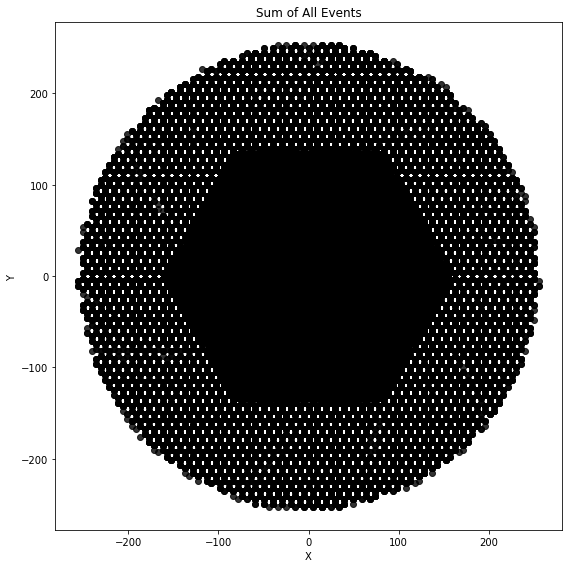

In [29]:
x_event = []
y_event = []
       
print("Scatter Plots: X, Y, Z")
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(DataList)): # loop on event number
    for j in range(len(DataList[i])): # loop on event rows
        x_event.append(DataList[i][j][0])
        y_event.append(DataList[i][j][1])


ax.scatter(x_event, y_event, c = "black", alpha=0.8)
#ax.scatter(np.zeros(len(y_event)), , c = "blue", alpha=0.8)
ax.set_title("Sum of All Events")
ax.set_xlabel("X")
ax.set_ylabel("Y ")
#ax.set_xticks(np.arange(0, 1, 1))
#ax.set_yticks(np.arange(0, 1., 1))
#ax.set_xlim(0,+10)
#ax.set_ylim(0,+10)
#plt.grid()




fig.tight_layout()
plt.show()



In [ ]:
x_event.sort()
y_event.sort()

print("x spacing: ", 2.45411777, "starting from 0 up to 255.22")
print("First cell: ", 2.45411777+2.45411777/2, "up to", 2.45411777-2.45411777/2)

print("Number of pixel in x direction: ", int(255.228271/2.45411777), " *2 + 1 = ", int(255.228271/2.45411777) *2 + 1)
print("Number of pixel on y the same event though spacing is more tricky")

x_uniques = np.unique(x_event)
y_uniques = np.unique(y_event)
#print(y_uniques.size)
#print(y_uniques[:])



### Transalte an event into an image


In [ ]:
# 1st inxes Event, 2nd y, 3rd x
images = np.zeros((len(DataList),209,209))
images_reduced = np.zeros((len(DataList),41,41))

for i in range(len(DataList)): # loop on event number
    for j in range(len(DataList[i])): # loop on event rows
        
        n_y = int(round(DataList[i][j][1]/2.45411777)) + 104 # calculate which y image pixel fired
        n_x = int(round(DataList[i][j][0]/2.45411777)) + 104 # calculate which x image pixel fired
        
        if images[i][n_y][n_x] < 255:
            images[i][n_y][n_x] =  images[i][n_y][n_x] + 1 
        else:
            print("Error = Exceeding 255 value per pixel")
            
for i in range(len(DataList)):
    for j in range(41):
        for h in range(41):
            images_reduced[i][j][h] =  images[i][j+84][h+84]  
        
print("Scatter Plots: X, Y, Z")
plot_row = 2
idx = 0
fig, ax = plt.subplots(plot_row,2,figsize=(18, plot_row*5))


for i in range(plot_row):
    for j in range(2):
        ax[i][j].imshow(images_reduced[idx], cmap='gray')
        if Labels[idx]>0.5:
            ax[i][j].set_title("Image "+ str(idx) + ": Reaction Event")
        else:
            ax[i][j].set_title("Image "+ str(idx) + ": Beam Event")
            
        ax[i][j].set_xlabel("Pixel X")
        ax[i][j].set_ylabel("Pixel Y")
        

        idx = idx +1

fig.tight_layout() # adjust automatically spacing between sublots
plt.show()

Why beam projection look always exactly the same? 
Anyway it seems working fine


### Convolutional Network

In [ ]:
#images = images_reduced3d

images = np.reshape(images_reduced, (images_reduced.shape[0], 41, 41, 1)) # image, x, y, ch
print(images.shape)

# Split the data into training and validation sets
images_train, images_val, labels_train, labels_val = train_test_split(images, Labels)
print(images_train.shape)
print(images_val.shape)

# Normalize the data
images_train_norm = normalize_image_data(images_train)
images_val_norm = normalize_image_data(images_val)

In [ ]:
my_model = tf.keras.Sequential()

my_model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(10, 10),
        activation='relu',
        padding='same',
        input_shape=images.shape[1:] # Shape of a single imag
                                )
        )

my_model.add(BatchNormalization())

my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(40, activation='relu'))
my_model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
my_model.compile(
    tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.8, beta_2=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

In [ ]:
from keras.utils import to_categorical

labe2 = to_categorical(labels_train)

In [ ]:
labe2

In [ ]:
history = my_model.fit(images_train[:400],
          labe2[:400],
          batch_size=128,
          epochs=20,
          validation_split=0.2);

In [ ]:
make_nn_plots(history,0.9)